# **Skin Cancer Lesion Classification**

References :

- https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy  (Best Comprehensive For Theory too)

- https://www.kaggle.com/fanconic/cnn-for-skin-cancer-detection

- https://www.kaggle.com/kocayinana/skin-cancer-recognition-with-resnet-50

- https://www.kaggle.com/vincee/intel-image-classification-cnn-keras

- https://www.kaggle.com/rohandeysarkar/ultimate-image-classification-guide-2020

- https://www.kaggle.com/pankul/image-classification-w-vgg16-weights

- https://github.com/bnsreenu/python_for_microscopists/blob/master/203b_skin_cancer_lesion_classification_V4.0.py

- https://github.com/bnsreenu/python_for_microscopists/blob/master/203a_skin_cancer_lesion_classification_V4.0_autokeras.py

- https://github.com/bnsreenu/python_for_microscopists/blob/master/202_2_ways_to_load_HAM10000_data.py



# https://youtu.be/qB6h5CohLbs

2 ways to load HAM10000 dataset for skin cancer lesion classification
Dataset link:

- https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

Data description: 
- https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf



---



The **7 classes of skin cancer lesions** included in this dataset are:
- Melanocytic nevi (nv)
- Melanoma (mel)
- Benign keratosis-like lesions (bkl)
- Basal cell carcinoma (bcc) 
- Actinic keratoses (akiec)
- Vascular lesions (vas)
- Dermatofibroma (df)


Actual image size is 600 X 450 

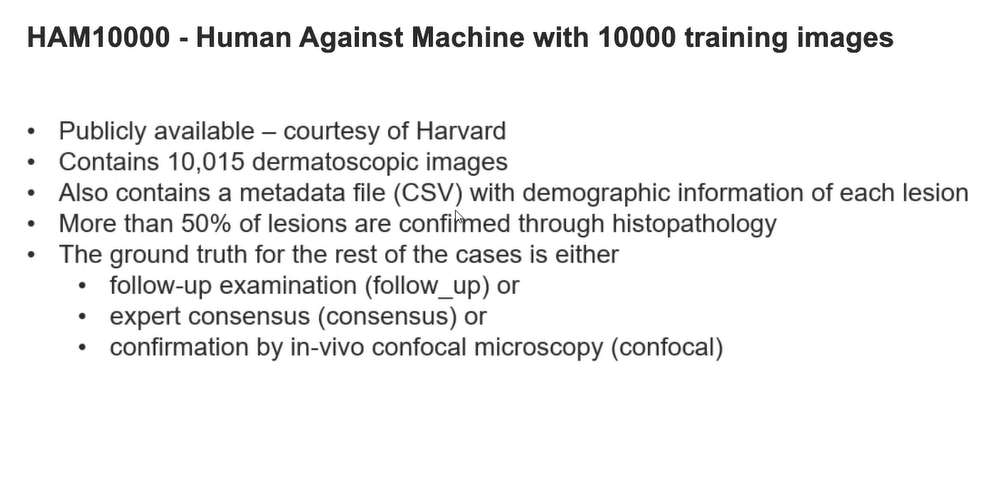

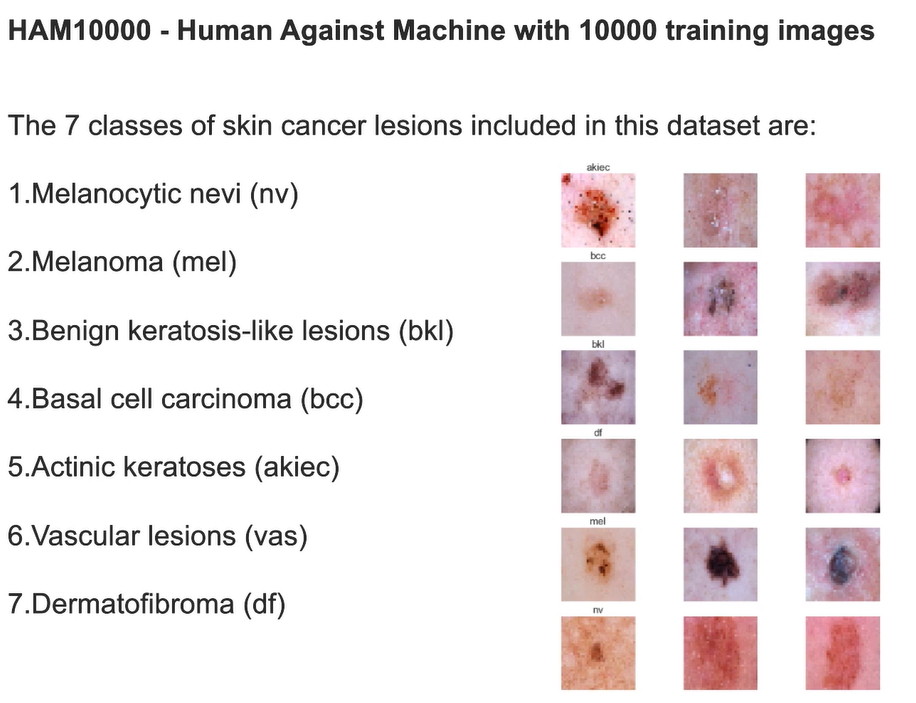

# Load all the required Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [ ]:
# Getting the present working directory
!pwd

/content


In [ ]:
# Mounting Google Drive : https://stackoverflow.com/questions/50479576/google-colab-changing-directory

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the directory to the Folder containing dataset

%cd /content/drive/My Drive/Colab_Files/Skin Cancer Data

/content/drive/My Drive/Colab_Files/Skin Cancer Data


In [ ]:
# Verify the current working directory
!pwd

/content/drive/My Drive/Colab_Files/Skin Cancer Data


In [ ]:
os.getcwd()

'/content/drive/My Drive/Colab_Files/Skin Cancer Data'

In [ ]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Read the csv file containing image names and corresponding labels
skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [ ]:
SIZE=32

In [ ]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx  ...     sex     localization label
1617  HAM_0007180  ISIC_0033272  mel  ...    male             face     4
8128  HAM_0007195  ISIC_0031923   nv  ...  female  lower extremity     5
2168  HAM_0001835  ISIC_0026652  mel  ...    male             back     4
1090  HAM_0000465  ISIC_0030583  bkl  ...  female            trunk     2
7754  HAM_0001720  ISIC_0034010   nv  ...    male          abdomen     5
8071  HAM_0006333  ISIC_0024424   nv  ...    male            trunk     5
7423  HAM_0004548  ISIC_0032832   nv  ...  female  upper extremity     5
8984  HAM_0006526  ISIC_0026671   nv  ...    male  lower extremity     5
2310  HAM_0003102  ISIC_0032389  mel  ...    male             face     4
7256  HAM_0004260  ISIC_0025525   nv  ...    male             back     5

[10 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


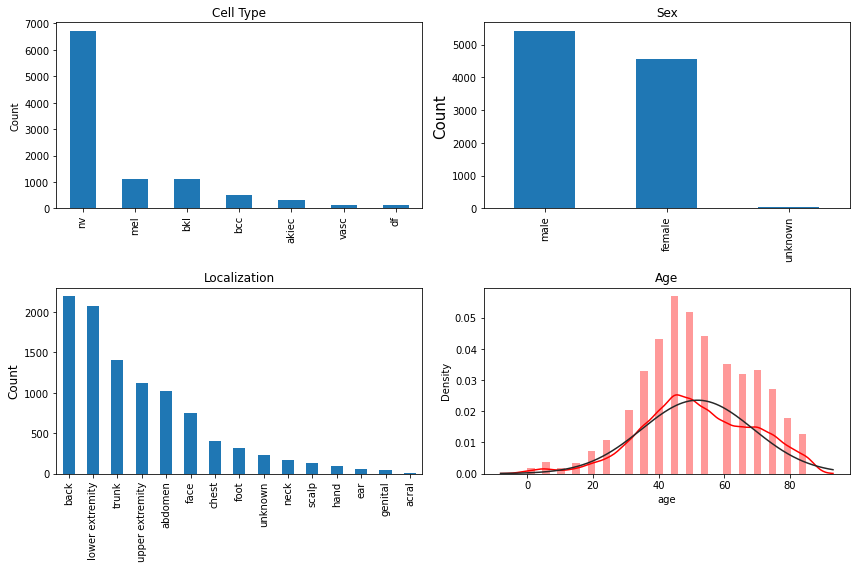

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [ ]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [ ]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [ ]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [ ]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

5    500
3    500
1    500
6    500
4    500
2    500
0    500
Name: label, dtype: int64


In [ ]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

In [ ]:
image_path

{'ISIC_0028320': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028320.jpg',
 'ISIC_0028296': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028296.jpg',
 'ISIC_0028306': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028306.jpg',
 'ISIC_0028327': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028327.jpg',
 'ISIC_0028310': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028310.jpg',
 'ISIC_0028308': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028308.jpg',
 'ISIC_0028301': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028301.jpg',
 'ISIC_0028318': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028318.jpg',
 'ISIC_0028324': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028324.jpg',
 'ISIC_0028325': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028325.jpg',
 'ISIC_0028337': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028337.jpg',
 'ISIC_0028329': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028329.jpg',
 'ISIC_0028332': 'data/HAM10000/HAM10000_images_part_1/ISIC_0028332.jpg',
 'ISIC_0028344': 'data/HAM10000/HAM100

In [ ]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


In [ ]:
skin_df_balanced['path'][:10]

9789    data/HAM10000/HAM10000_images_part_1/ISIC_0026...
9957    data/HAM10000/HAM10000_images_part_1/ISIC_0025...
9793    data/HAM10000/HAM10000_images_part_1/ISIC_0024...
9758    data/HAM10000/HAM10000_images_part_1/ISIC_0027...
9875    data/HAM10000/HAM10000_images_part_1/ISIC_0029...
9707    data/HAM10000/HAM10000_images_part_2/ISIC_0031...
9789    data/HAM10000/HAM10000_images_part_1/ISIC_0026...
9808    data/HAM10000/HAM10000_images_part_1/ISIC_0027...
9901    data/HAM10000/HAM10000_images_part_2/ISIC_0029...
9774    data/HAM10000/HAM10000_images_part_2/ISIC_0031...
Name: path, dtype: object

In [ ]:
skin_df_balanced['path'].unique()

array(['data/HAM10000/HAM10000_images_part_1/ISIC_0026645.jpg',
       'data/HAM10000/HAM10000_images_part_1/ISIC_0025780.jpg',
       'data/HAM10000/HAM10000_images_part_1/ISIC_0024450.jpg', ...,
       'data/HAM10000/HAM10000_images_part_1/ISIC_0025425.jpg',
       'data/HAM10000/HAM10000_images_part_2/ISIC_0031201.jpg',
       'data/HAM10000/HAM10000_images_part_2/ISIC_0033123.jpg'],
      dtype=object)

In [ ]:
skin_df['image_id']

0        ISIC_0027419
1        ISIC_0025030
2        ISIC_0026769
3        ISIC_0025661
4        ISIC_0031633
             ...     
10010    ISIC_0033084
10011    ISIC_0033550
10012    ISIC_0033536
10013    ISIC_0032854
10014    ISIC_0032258
Name: image_id, Length: 10015, dtype: object

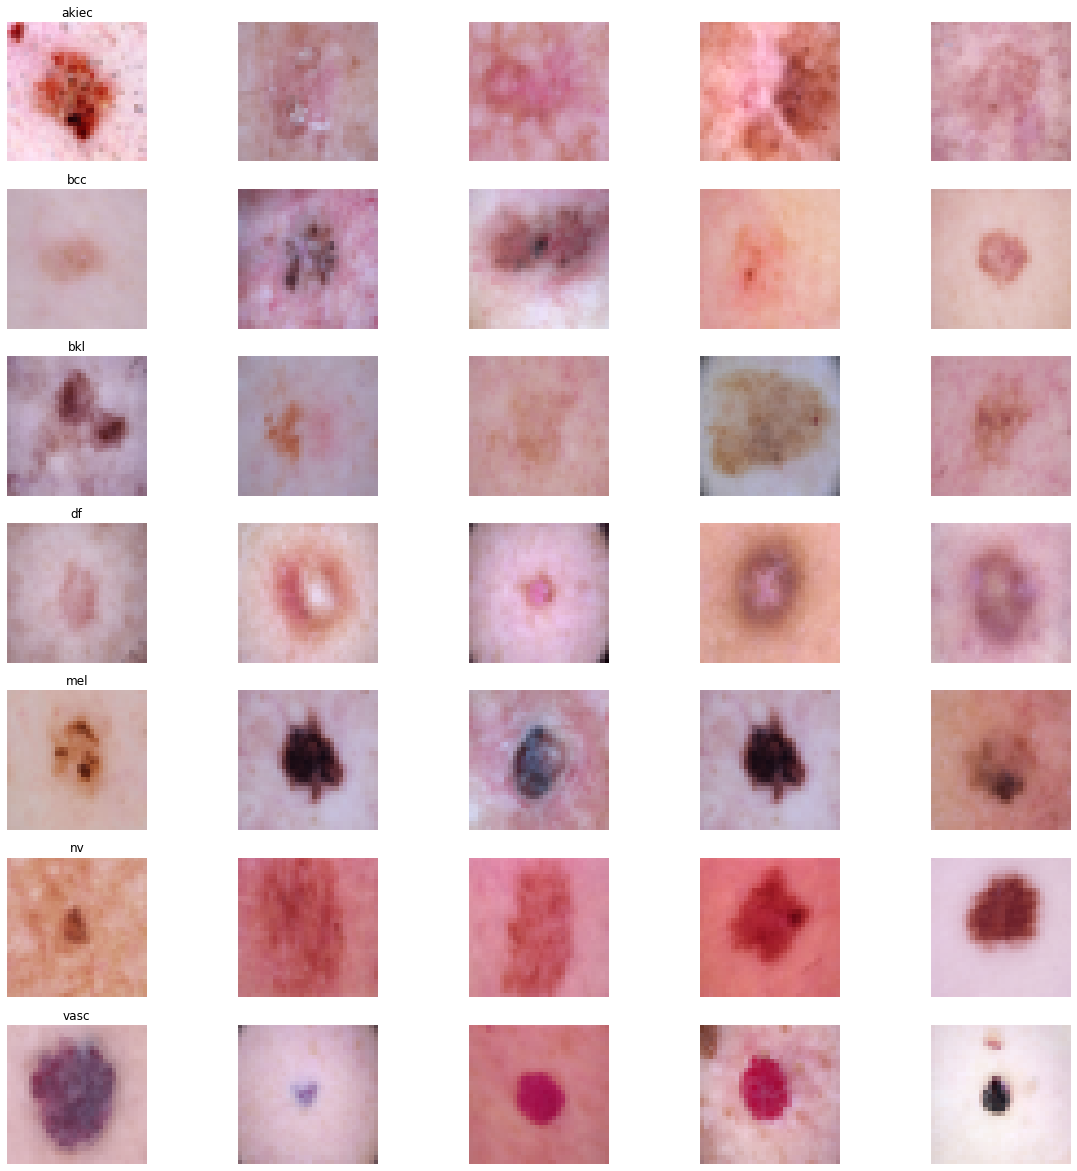

In [ ]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [ ]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          7

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


In [ ]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)


Epoch 1/50
165/165 - 25s - loss: 1.5663 - acc: 0.3550 - val_loss: 1.5728 - val_acc: 0.3657
Epoch 2/50
165/165 - 25s - loss: 1.5180 - acc: 0.3794 - val_loss: 1.4619 - val_acc: 0.4114
Epoch 3/50
165/165 - 24s - loss: 1.4527 - acc: 0.4088 - val_loss: 1.3920 - val_acc: 0.4194
Epoch 4/50
165/165 - 26s - loss: 1.3818 - acc: 0.4533 - val_loss: 1.3917 - val_acc: 0.4651
Epoch 5/50
165/165 - 26s - loss: 1.3371 - acc: 0.4777 - val_loss: 1.3123 - val_acc: 0.4857
Epoch 6/50
165/165 - 23s - loss: 1.3089 - acc: 0.4865 - val_loss: 1.2598 - val_acc: 0.5120
Epoch 7/50
165/165 - 23s - loss: 1.2708 - acc: 0.5093 - val_loss: 1.2510 - val_acc: 0.5051
Epoch 8/50
165/165 - 25s - loss: 1.2249 - acc: 0.5280 - val_loss: 1.2064 - val_acc: 0.5166
Epoch 9/50
165/165 - 23s - loss: 1.2234 - acc: 0.5295 - val_loss: 1.2390 - val_acc: 0.5131
Epoch 10/50
165/165 - 23s - loss: 1.2378 - acc: 0.5139 - val_loss: 1.1879 - val_acc: 0.5520
Epoch 11/50
165/165 - 24s - loss: 1.1904 - acc: 0.5341 - val_loss: 1.1695 - val_acc: 0.54

In [ ]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 2s 68ms/step - loss: 0.8128 - acc: 0.7166
Test accuracy: 0.7165714502334595


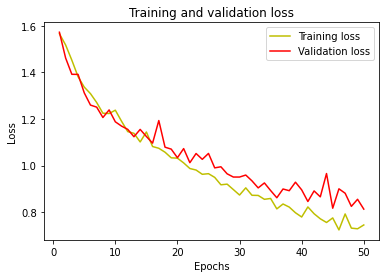

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

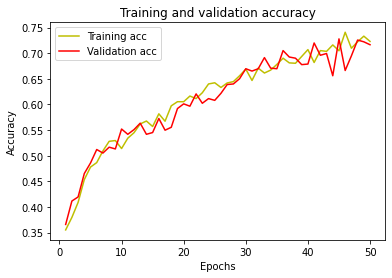

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

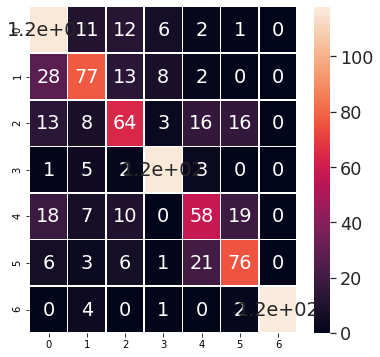

In [ ]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

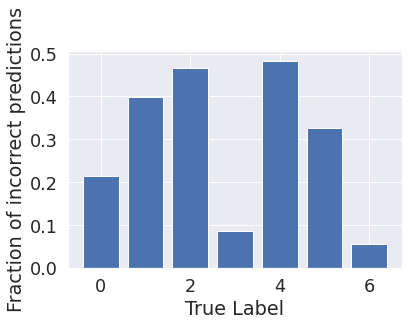

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')